# Potential Player
## Objective
Identify users not playing any Nexon game, but have high likelihood of playing one of Nexon's game

## Methodology
We will try to identify players sharing similar profile as Nexon players, such as purchasing and gaming behavior. Depending on how distinct the player profile is for each Nexon game, we may need to build 3 separate models for each game.  
  
The assumption here is that if, for example, most MapleStory players only spend about 30 hours playing a week, it could mean that the nature of the game or the gaming community is suitable for people who can devote 30 hours a week playing game. Thus, people who do not spend around the same time are likely not suitable for MapleStory and therefore have less likelihood of playing MapleStory.  
  
Here we will create user profile (features) and build K-nearest Neighbor classification model to see the likelihood of players for playing each Nexon game (MapltStory, Mabinogi, and Vindictus). Our target here are players who are clustered together as Nexon players.

## Steps
1. Label games with relevant genre to slim down number of available features
2. feature genaration such as purchase genre Y, play time for genre X, % time playing genre X, # of games played, ...etc.
3. model building

## Brainstorm/Notes
1. look into people who play low-res games (games with earlier published days) as they may have hardware limtations
2. look into people who play exclusively MMORPG

## Obsticles
1. There's no timestamp for time information. 
    * Unable to distinguish between players who play lots of hours in short period of time vs one who plays moderate amount but over a long horizon.
    * Unable to tell if certain game was played recently and if a player has moved onto to a different genre of games

In [1]:
import numpy as np
import pandas as pd
import utility

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# read data
df = pd.read_csv('data/steam-200k.csv', header=None)\
       .rename(columns={0:'id', 1:'game', 2:'action', 3:'value'})\
       .astype({'id':str})\
       .iloc[:, :4] # drop last column
df = df.drop_duplicates()
df.head(3)

,id,game,action,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0


## EDA
We will perform analysis on players who played Nexon game (MapleStory, Mabinogi, Vindictus) vs those who have nevery played Nexon game  
  
__Note:__ when we flag Nexon player, we only flags players who have "play" action. Users with only "purchase" action and no play action is not considered Nexon player.

In [3]:
# flag players who has played Nexon game
df = utility.flag_nexon_player(df)

In [4]:
# here we run the same general EDA on Nexon player
# actual EDA code are in utility.py, calling function here for readability
df_nexon = df[df['flg_NX'] == 1].reset_index(drop=True)
utility.eda_general(df_nexon)

Number of records:          5824
Number of unique User ID:   45
Number of games:            1560

	Action Count: 
purchase    3801
play        2023
Name: action, dtype: int64

Number of Purchasing Player: 45
% of Purchasing Player: 100.0%

	Summary Statistics on Play Time:
count    2023.000000
mean       23.405685
std        91.997070
min         0.100000
25%         0.900000
50%         3.800000
75%        13.300000
max      2563.000000
Name: value, dtype: float64

	Summary Statistics on Number of Games Played:
count    2023.000000
mean       82.405833
std        49.377679
min         1.000000
25%        38.000000
50%        83.000000
75%       109.000000
max       169.000000
Name: game_freq, dtype: float64

	Summary Statistics on Number of Games Purchase:
count    3801.000000
mean      240.102341
std       222.800806
min         3.000000
25%        78.000000
50%       139.000000
75%       413.000000
max       666.000000
Name: purch_freq, dtype: float64

	Top 10 Games Purchased
Team F

In [5]:
# general EDA on non-Nexon player
df_non_NX = df[df['flg_NX'] != 1]
utility.eda_general(df_non_NX)

Number of records:          193469
Number of unique User ID:   12348
Number of games:            5116

	Action Count: 
purchase    125003
play         68466
Name: action, dtype: int64

Number of Purchasing Player: 11305
% of Purchasing Player: 92.0%

	Summary Statistics on Play Time:
count    68466.000000
mean        49.630709
std        232.118551
min          0.100000
25%          1.000000
50%          4.500000
75%         19.300000
max      11754.000000
Name: value, dtype: float64

	Summary Statistics on Number of Games Played:
count    68454.000000
mean        56.220761
std         74.122473
min          1.000000
25%          8.000000
50%         29.000000
75%         76.000000
max        498.000000
Name: game_freq, dtype: float64

	Summary Statistics on Number of Games Purchase:
count    125003.000000
mean        129.299897
std         179.676564
min           1.000000
25%          15.000000
50%          59.000000
75%         163.000000
max        1068.000000
Name: purch_freq, dty

### EDA Summary
Some rudimentary analysis comparing summary statitics between Nexon players and non-Nexon players shows that Nexon players on average have played more games, purchased more games, but spend less time playing games.  
The game purchased profile is also quite different with Nexon players having more presence of Sandbox type of games. Although one can certainly argue that those games are popular such that everyone, including Nexon players, plays them.
  
We will try to visualize the relationship using boxplot  

In [6]:
df.head()

,id,game,action,value,flg_MS,flg_MA,flg_VN,flg_NX,player_type
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0.0,0.0,0.0,0.0,non_Nexon
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0.0,0.0,0.0,0.0,non_Nexon
2,151603712,Fallout 4,purchase,1.0,0.0,0.0,0.0,0.0,non_Nexon
3,151603712,Fallout 4,play,87.0,0.0,0.0,0.0,0.0,non_Nexon
4,151603712,Spore,purchase,1.0,0.0,0.0,0.0,0.0,non_Nexon


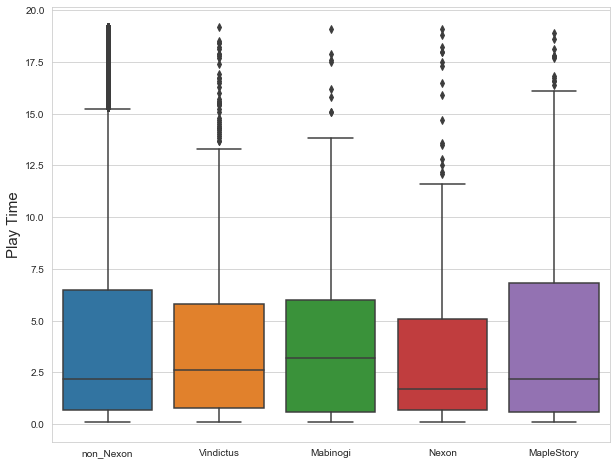

In [207]:
# remove records with play time > 3rd quartile of non_Nexon players, or 19.3
# for better visualization, otherwise the scale makes visualization hard to interpret
df_play = df[(df['action'] == 'play') & (df['value'] < 19.3)]

plt.figure(figsize=(10, 8))
sns.set_style('whitegrid')
ax = sns.boxplot(y='value', x='player_type', data=df_play)
ax.set_xlabel('', fontsize=15)
ax.set_ylabel('Play Time', fontsize=15)
plt.show()

### Interpretation
From here we can see that Vindictus and Mabinogi players tend to spend more time playing than non_Nexon players, howevery, the variance in time played is less. The distribution for MapleStory is fairly to the non_Nexon players, while players who have played more than 1 Nexon games tends to spend less time playing than non_Nexon players.  
  
The take away here is that _play time_ may be good indicatory for Vindictus, Mabinogi, and players who play more than 1 Nexon games, but not as effective for MapleStory players.

# K-Nearest Neighbor
Here we will implement K-near Neighbor algorithm, which uses Enclidean distances of features and does a plurality vote for the class of an object. The object is assigned the class most common among its k nearest neighbors.  
  
KNN works best with continuous features (it's hard to determine distances between categorical variables). We will generate featrues to fulfill this criteria. Specifically, we will categorize games into different genre and work off of genre instead of game title.  
  
To save time, we'll limit the scope to 5 genres and randomly assign them to games.

## Feature Generation

In [8]:
# get list of games
n_game = df['game'].nunique()
print(f'Number of unique games: {n_game}')

Number of unique games: 5155


In [9]:
# add genre to master dataframe
df = utility.add_genre(df)

Now that we have genre, we can start working on creating features. We'll start with the following:
* play time by genre
* number of purchase by genre
* % of time played by genre
* % of purchase by genre

In [11]:
df_knn = df[['id', 'player_type', 'genre', 'action', 'value']].reset_index(drop=True)

In [13]:
%%time
df_features = utility.feature_generation(df_knn)

CPU times: user 8.06 s, sys: 108 ms, total: 8.17 s
Wall time: 8.2 s


## KNN Model

In [71]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report

In [104]:
# convert pandas dataframe to numpy for sklearn training spec
df_label = df[['id', 'flg_NX']].drop_duplicates()\
                               .reset_index(drop=True)\
                               .rename(columns={'flg_NX':'label'})
df_final = df_features.merge(df_label, on='id', how='inner')

print(df_final['label'].value_counts())

0.0    11305
1.0       45
Name: label, dtype: int64


In [164]:
# here we see class imbalance, we will down sample this time to 500 samples
seed = 316
df_positive = df_final[df_final['label'] == 1]
df_negative = df_final[df_final['label'] == 0].sample(frac=.05, random_state=seed)

df_final_ds = pd.concat([df_negative, df_positive])

In [165]:
df_final_ds.shape

(610, 22)

In [116]:
y = df_final_ds.pop('label')\
            .astype(int)\
            .to_numpy()
x = df_final_ds.drop('id', axis=1)\
            .to_numpy()

In [117]:
# KNN uses euclidean distances so need to scale all features so they use the same unit
x = scale(x)

In [118]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=316)

In [119]:
print(f'Training size: {x_train.shape[0]}')
print(f'Testing size: {x_test.shape[0]}')

Training size: 488
Testing size: 122


In [158]:
k = 1
knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train, y_train)    

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [159]:
y_true, y_pred = y_test, knn.predict(x_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       113
           1       0.57      0.44      0.50         9

    accuracy                           0.93       122
   macro avg       0.76      0.71      0.73       122
weighted avg       0.93      0.93      0.93       122



Here we want to optimize recall to capture all the players that may be interested in playing Nexon game. We found the best metrics to be at k = 1, where precision/recall for positive case is 57% and 44% respectively.

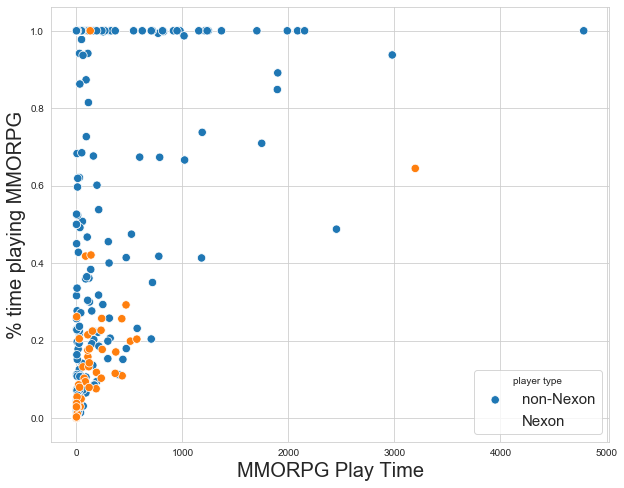

In [213]:
plt.figure(figsize=(10, 8))
sns.set_style('whitegrid')
ax = sns.scatterplot(y='ppt_mmo', x='pt_mmo', hue='label', data=df_final_ds, s=70)
ax.set_xlabel('MMORPG Play Time', fontsize=20)
ax.set_ylabel('% time playing MMORPG', fontsize=20)
plt.legend(title='player type', labels=['non-Nexon', 'Nexon'], fontsize=15)
plt.show()

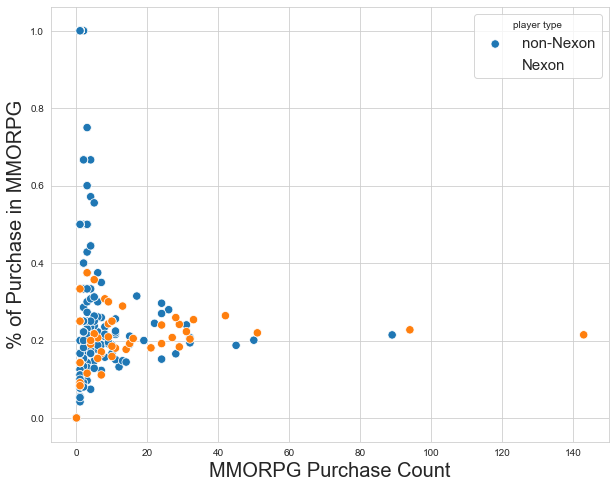

In [214]:
plt.figure(figsize=(10, 8))
sns.set_style('whitegrid')
ax = sns.scatterplot(y='ppr_mmo', x='pr_mmo', hue='label', data=df_final_ds, s=70)
ax.set_xlabel('MMORPG Purchase Count', fontsize=20)
ax.set_ylabel('% of Purchase in MMORPG', fontsize=20)
plt.legend(title='player type', labels=['non-Nexon', 'Nexon'], fontsize=15)
plt.show()

In [166]:
df_final_ds.head()

,pt_action,pt_fps,pt_mmo,pt_moba,pt_rts,pr_action,pr_fps,pr_mmo,pr_moba,pr_rts,...,ppt_mmo,ppt_moba,ppt_rts,ppr_action,ppr_fps,ppr_mmo,ppr_moba,ppr_rts,id,label
2206,0.0,2.2,6.7,15.3,0.0,0.0,2.0,1.0,1.0,0.0,...,0.27686,0.632231,0.0,0.000000,0.500000,0.25,0.250000,0.0,149291366,0.0
9690,23.0,4.1,0.0,15.3,0.0,1.0,1.0,0.0,1.0,0.0,...,0.00000,0.360849,0.0,0.333333,0.333333,0.00,0.333333,0.0,57541240,0.0
7468,0.0,0.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.00000,0.000000,0.0,0.000000,0.000000,1.00,0.000000,0.0,260149777,0.0
10353,195.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.00000,0.000000,0.0,0.500000,0.000000,0.00,0.500000,0.0,75753011,0.0
4560,0.0,0.0,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.00000,0.000000,0.0,0.000000,0.000000,1.00,0.000000,0.0,192969933,0.0
